In [16]:
!pip install anvil-uplink

  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [17]:
import anvil.server

In [18]:
anvil.server.connect("server_HY5LXYU4CT55Q7RWFCGTODZV-PW3FAWZMWJJWCTDA")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "klasifikasi burung" as SERVER


In [20]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Colab Notebooks/dataset.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


Label kelas: ['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'AFRICAN PYGMY GOOSE', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN FLAMINGO', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL']
Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.1310 - loss: 2.6271 - val_accuracy: 0.0000e+00 - val_loss: 10.6480
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4175 - loss: 1.7407 - val_accuracy: 0.0031 - val_loss: 13.7021
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6084 - loss: 1.1789 - val_accuracy: 0.0042 - val_loss: 17.6455
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7504 - loss: 0.7906 - val_accuracy: 0.0031 - val_loss: 15.6653
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 

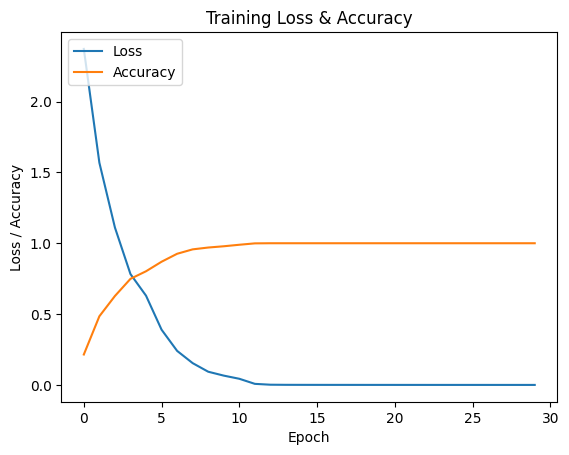

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7303 - loss: 10.2670
Akurasi testing: 0.6200


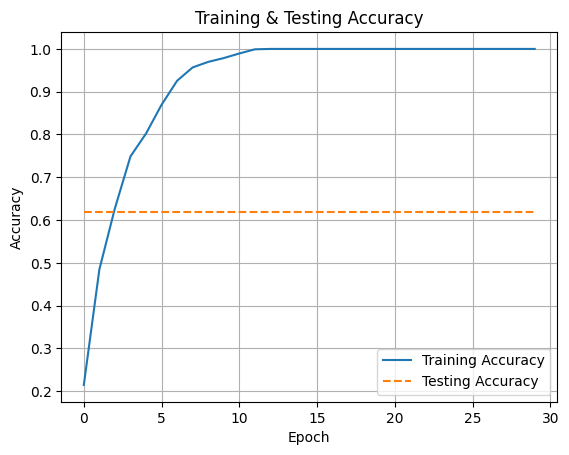

In [25]:
# Import Library
import os
import zipfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

# Path Data
extract_path = "/content/Burung"
path_train = os.path.join(extract_path, "train")
path_test = os.path.join(extract_path, "test")

# Baca Label Kelas
LabelKelas = sorted([d for d in os.listdir(path_train) if os.path.isdir(os.path.join(path_train, d))])
print("Label kelas:", LabelKelas)

# Fungsi LoadCitraTraining_Load Dataset
def LoadCitraTraining(sDir, LabelKelas):
    JumlahKelas = len(LabelKelas)
    TargetKelas = np.eye(JumlahKelas)
    X, T = [], []

    for i, label in enumerate(LabelKelas):
        DirKelas = os.path.join(sDir, label)
        files = os.listdir(DirKelas)

        for f in files:
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(DirKelas, f)
                img = np.double(cv2.imread(path, 1))
                img = cv2.resize(img, (128, 128))
                img = img / 255.0
                img = img.astype('float32')
                X.append(img)
                T.append(TargetKelas[i])

    X = np.array(X).astype('float32')
    T = np.array(T).astype('float32')
    return X, T

# Fungsi ModelDeepLearningCNN_Model CNN
def ModelDeepLearningCNN(JumlahKelas):
    input_img = Input(shape=(128, 128, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(JumlahKelas, activation='softmax')(x)

    model = Model(input_img, x)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Fungsi Traning CNN
def TrainingCNN(JumlahEpoh, DirektoriDataSet, LabelKelas, NamaFileModel='model_burung.h5'):
    X, D = LoadCitraTraining(DirektoriDataSet, LabelKelas)
    model = ModelDeepLearningCNN(len(LabelKelas))
    history = model.fit(X, D, epochs=JumlahEpoh, shuffle=True, validation_split=0.3)
    model.save(NamaFileModel)
    return model, history

# Parameter & Training
JumlahEpoch = 30
FileModel = "model_burung.h5"
ModelCNN, history = TrainingCNN(JumlahEpoch, path_train, LabelKelas, FileModel)

# Grafik Akurasi & Loss
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('Training Loss & Accuracy')
plt.ylabel('Loss / Accuracy')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Accuracy'], loc='upper left')
plt.show()

# Testing: Evaluasi Model
# 2. Load data testing
X_test, T_test = LoadCitraTraining(path_test, LabelKelas)

# 3. Evaluasi akurasi testing
loss_test, acc_test = ModelCNN.evaluate(X_test, T_test)
print("Akurasi testing: {:.4f}".format(acc_test))

# 4. Ambil akurasi training dari history
train_acc = history.history['accuracy']

# 5. Buat list akurasi testing sepanjang jumlah epoch (agar bisa digrafikkan bersama)
test_acc = [acc_test] * len(train_acc)

# 6. Plot grafik akurasi training dan testing
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Testing Accuracy', linestyle='--')
plt.title('Training & Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# integrasi antara model CNN dengan antarmuka web Anvil
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

anvil.server.connect("server_HY5LXYU4CT55Q7RWFCGTODZV-PW3FAWZMWJJWCTDA")

model = load_model("model_burung.h5")

def klasifikasi_gambar(image_path, model, LabelKelas):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)

    max_prob = pred.max()
    if max_prob > 0.5:
        idx = np.argmax(pred)
        persen = round(max_prob * 100, 2)
        return f"{LabelKelas[idx]}({persen}%)"
    return "Tidak diketahui"

@anvil.server.callable
def predict_from_upload(file):
    # Simpan file ke disk
    with open("temp.jpg", "wb") as f:
        f.write(file.get_bytes())

    # Baca gambar, proses, prediksi
    img = cv2.imread("temp.jpg")
    img = cv2.resize(img, (128, 128))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)

    # Prediksi dengan model
    pred = ModelCNN.predict(img)

    max_prob = pred.max()
    if max_prob > 0.5:
        idx = np.argmax(pred)
        persen = round(max_prob * 100, 2)
        return f"{LabelKelas[idx]}({persen}%)"
    else:
        return "Tidak dikenali"

try:
    anvil.server.wait_forever()
except KeyboardInterrupt:
    print("Program dihentikan.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Program dihentikan.


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
